# Model Final

This is a script showing results **final model**.

- **Backbone:** GATv2
- **Graph type:** Homogeneous
- **Loss function:** Bayesian personalized ranking
- **Embeddings used:** weighted average
- **Keyword popularity used:**

*This model upgrades the state-of-the-art graph neural network methodology with novel graph transformer approach.*

## **Setting up environment**

---



### Loading libraries

In [1]:
import os
import sys

sys.path.insert(0, os.path.abspath(".."))

import torch
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Optional

from torch import Tensor
from torch.nn import ModuleList
from torch.optim import Optimizer
from torch_geometric.typing import Adj, OptTensor
from torch_geometric.nn.conv import TransformerConv
from torch.optim.lr_scheduler import LRScheduler
from torch_geometric.data import Data

from util.torch_geometric import get_results
from util.homogeneous.dataset import (DatasetEuCoHM, load_dataset)
from util.homogeneous.model import ModelEuCoHM
from util.homogeneous.train import (
    train,
    test,
    evaluate
)

### Global variables

In [2]:
# Dataset save filepath
dataset_save_filepath_prefix = '../data/dataset_homogeneous_periodical_decay_full'
# Device name
device = 'cpu'

# Model configuration
model_config = dict(
    hidden_channels=128,
    learning_rate=1e-3,
    num_layers=4,
    num_epochs=50,
    num_recommendations=10,
    num_bootstrap=10
)
# Set seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

## Model training


---



### Model definition

In [3]:
class ModelEuCoFinal(ModelEuCoHM):
    def __init__(self,
                 input_channels: int,
                 hidden_channels: int,
                 num_layers: int,
                 num_recommendations: int,
                 author_node_id_map: dict,
                 author_id_map: dict,
                 device: str = 'cpu'):
        super().__init__(
            input_channels=input_channels,
            hidden_channels=hidden_channels,
            num_layers=num_layers,
            num_recommendations=num_recommendations,
            author_node_id_map=author_node_id_map,
            author_id_map=author_id_map,
            device=device
        )

### Training the model

In [4]:
def load_model(data: Data, model_config: dict, author_node_id_map: dict, author_id_map: dict):
    # Initialize the model
    model = ModelEuCoFinal(
        input_channels=data.num_features,
        hidden_channels=model_config['hidden_channels'],
        num_recommendations=model_config['num_recommendations'],
        num_layers=model_config['num_layers'],
        author_node_id_map=author_node_id_map,
        author_id_map=author_id_map
    ).to(device)
    
    # Initialize the optimizer
    optimizer: Optimizer = torch.optim.Adam(
        params=model.parameters(),
        lr=model_config['learning_rate']
    )
    
    # Initialize the scheduler
    scheduler: LRScheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.5,
        patience=3
    )
    
    return model, data, optimizer, scheduler

In [5]:
results: list = list()
for bootstrap_id in range(model_config['num_bootstrap']):
    print(f'Processing bootstrap dataset ix={bootstrap_id}...')
    dataset_filepath = f'{dataset_save_filepath_prefix}_b{bootstrap_id}.pkl'
    data, author_id_map, author_node_id_map = load_dataset(dataset_filepath=dataset_filepath, device=device)
    model, data, optimizer, scheduler = load_model(data, model_config, author_node_id_map, author_id_map)
    for epoch in range(1, model_config['num_epochs'] + 1):
        # ------ Train
        train_loss: float = train(
            model=model,
            data=data,
            optimizer=optimizer
        )
        scheduler.step(train_loss)
        print(f"Epoch {epoch}: train loss: {train_loss:.3f}")
        results.append({'Epoch': epoch, 'Train Loss': train_loss, 'Bootstrap ID': bootstrap_id})

Processing bootstrap dataset ix=0...


/home/eucollab/eutopia-colllaboration/ecr-recommender/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

Epoch 1: train loss: 0.013
Epoch 2: train loss: 0.009
Epoch 3: train loss: 0.007
Epoch 4: train loss: 0.006
Epoch 5: train loss: 0.006
Epoch 6: train loss: 0.006
Epoch 7: train loss: 0.005
Epoch 8: train loss: 0.005
Epoch 9: train loss: 0.005
Epoch 10: train loss: 0.005
Epoch 11: train loss: 0.004
Epoch 12: train loss: 0.004
Epoch 13: train loss: 0.004
Epoch 14: train loss: 0.004
Epoch 15: train loss: 0.004
Epoch 16: train loss: 0.004
Epoch 17: train loss: 0.003
Epoch 18: train loss: 0.003
Epoch 19: train loss: 0.003
Epoch 20: train loss: 0.003
Epoch 21: train loss: 0.003
Epoch 22: train loss: 0.003
Epoch 23: train loss: 0.003
Epoch 24: train loss: 0.003
Epoch 25: train loss: 0.003
Epoch 26: train loss: 0.003
Epoch 27: train loss: 0.003
Epoch 28: train loss: 0.003
Epoch 29: train loss: 0.002
Epoch 30: train loss: 0.002
Epoch 31: train loss: 0.003
Epoch 32: train loss: 0.003
Epoch 33: train loss: 0.002
Epoch 34: train loss: 0.002
Epoch 35: train loss: 0.002
Epoch 36: train loss: 0.002
E

### Model evaluation

In [6]:
results_df = pd.DataFrame(results)
results_df.to_csv(f'../results/results_Model_bootstrapped_final.csv', index=False)

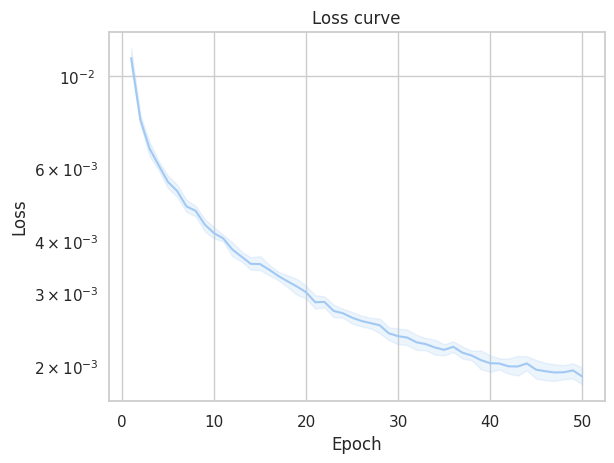

In [7]:
# Generate loss curve
# Train loss
sns.lineplot(data=results_df, x='Epoch', y='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.yscale('log')
plt.show()

In [8]:
from util.postgres import create_sqlalchemy_engine, save_author_embeddings
from box import Box
from sqlalchemy import Engine

# Read settings from config file
config: Box = Box.from_yaml(filename="../config.yaml")

# Connect to Postgres
engine: Engine = create_sqlalchemy_engine(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)

# Save author embeddings to Postgres
save_author_embeddings(
    model=model,
    engine=engine,
    x=data.x,
    edge_index=data.edge_index,
    author_id_map=author_id_map,
    target_table='author_embedding'
)